In [1]:
import os
from pathlib import Path
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
import geoutils as gu
import xdem
from pprint import pprint
import altair as alt    
from rasterio.enums import Resampling
import json 
import seaborn as sns
from shapely import wkt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from functools import reduce

# Read file lists

## Xdem outputs

In [2]:
cum_files = glob.glob('outputs/cum_dv_df/*.pickle') ###
largerarea_cum_files = glob.glob('outputs/larger_area/cum_dv_df/*.pickle') ###
bounding_cum_files = glob.glob('outputs/bounding_cum_dv_df/*.pickle') ###
threshold_pos_files = glob.glob('outputs/threshold_pos_dv_df/*.pickle') 
threshold_neg_files = glob.glob('outputs/threshold_neg_dv_df/*.pickle')
hillslope_threshold_pos_files = glob.glob('outputs/hillslope_threshold_pos_dv_df/*.pickle') 
hillslope_threshold_neg_files = glob.glob('outputs/hillslope_threshold_neg_dv_df/*.pickle')
fluvial_threshold_pos_files = glob.glob('outputs/fluvial_threshold_pos_dv_df/*.pickle') 
fluvial_threshold_neg_files = glob.glob('outputs/fluvial_threshold_neg_dv_df/*.pickle')

cum_process_files = glob.glob('outputs/cum_dv_df_process/*.pickle')
cum_process_bounding_files = glob.glob('outputs/cum_dv_df_process_bounding/*.pickle')
# dv_df_process_sums_process/
process_threshold_neg_files = glob.glob('outputs/threshold_neg_dv_df_process_sums_process/*.pickle')
process_threshold_pos_files = glob.glob('outputs/threshold_pos_dv_df_process_sums_process/*.pickle')

process_sums_files = glob.glob("outputs/dv_df_process_sums_process/*.pickle")

## Xsection outputs

In [3]:
slope_halfkm_files = glob.glob('outputs/slope_grouped_halfkm/*.pickle')
slope_km_files = glob.glob('outputs/slope_grouped_km/*.pickle')
elevation_files = glob.glob('outputs/elevation_profiles/*.pickle')

# Load datasets

## Xdem outputs

### Gross (pos and neg) datasets thresholded

In [4]:
threshold_pos_df = pd.concat(
    [pd.read_pickle(f) for f in threshold_pos_files]
)
threshold_pos_df['type'] = "positive"
threshold_neg_df = pd.concat(
    [pd.read_pickle(f) for f in threshold_neg_files]
)
threshold_neg_df['type'] = "negative"
gross_data_df = pd.concat([threshold_neg_df, threshold_pos_df])

### Cumulative net and bounding datasets

In [5]:

cum_df = pd.concat(
    [pd.read_pickle(f) for f in cum_files]
)

bounding_cum_df = pd.concat(
    [pd.read_pickle(f) for f in bounding_cum_files]
)

bounding_cum_df['bounding'] = True
cum_df['bounding'] = False

cum_and_bounding_cum_df = pd.concat([bounding_cum_df, cum_df])

### Cumulative net dataset for larger area

In [6]:

largerarea_cum_df = pd.concat(
    [pd.read_pickle(f) for f in largerarea_cum_files]
)

### Gross (pos and neg) datasets thresholded, by erosion type

In [7]:
hillslope_threshold_pos_df = pd.concat([pd.read_pickle(f) for f in hillslope_threshold_pos_files])
hillslope_threshold_pos_df['type'] = "positive"
hillslope_threshold_pos_df['process'] = "hillslope"

hillslope_threshold_neg_df = pd.concat([pd.read_pickle(f) for f in hillslope_threshold_neg_files])
hillslope_threshold_neg_df['type'] = "negative"
hillslope_threshold_neg_df['process'] = "hillslope"

fluvial_threshold_pos_df = pd.concat([pd.read_pickle(f) for f in fluvial_threshold_pos_files])
fluvial_threshold_pos_df['type'] = "positive"
fluvial_threshold_pos_df['process'] = "fluvial"

fluvial_threshold_neg_df = pd.concat([pd.read_pickle(f) for f in fluvial_threshold_neg_files])
fluvial_threshold_neg_df['type'] = "negative"
fluvial_threshold_neg_df['process'] = "fluvial"


gross_data_bytype_df = pd.concat([hillslope_threshold_pos_df, hillslope_threshold_neg_df, fluvial_threshold_pos_df, fluvial_threshold_neg_df])

### Convert "Annual Mass Wasted" into 1000s of cubic meters

In [8]:
gross_data_df["Annual Mass Wasted"] = gross_data_df["Annual Mass Wasted"]/1000
gross_data_df["Upper CI"] = gross_data_df["Upper CI"]/1000
gross_data_df["Lower CI"] = gross_data_df["Lower CI"]/1000

cum_and_bounding_cum_df["volume"] = cum_and_bounding_cum_df["volume"]/1000
cum_and_bounding_cum_df["cumulative volume"] = cum_and_bounding_cum_df["cumulative volume"]/1000
cum_and_bounding_cum_df["Upper CI"] = cum_and_bounding_cum_df["Upper CI"]/1000
cum_and_bounding_cum_df["Lower CI"] = cum_and_bounding_cum_df["Lower CI"]/1000

largerarea_cum_df["volume"] = largerarea_cum_df["volume"]/1000
largerarea_cum_df["cumulative volume"] = largerarea_cum_df["cumulative volume"]/1000
largerarea_cum_df["Upper CI"] = largerarea_cum_df["Upper CI"]/1000
largerarea_cum_df["Lower CI"] = largerarea_cum_df["Lower CI"]/1000

gross_data_bytype_df["Annual Mass Wasted"] = gross_data_bytype_df["Annual Mass Wasted"]/1000
gross_data_bytype_df["Upper CI"] = gross_data_bytype_df["Upper CI"]/1000
gross_data_bytype_df["Lower CI"] = gross_data_bytype_df["Lower CI"]/1000

## Xsection outputs

In [9]:
slope_halfkm_df = pd.concat(
    [pd.read_pickle(f) for f in slope_halfkm_files]
)
slope_km_df = pd.concat(
    [pd.read_pickle(f) for f in slope_km_files]
)
elevation_df = pd.concat(
    [pd.read_pickle(f) for f in elevation_files]
)

# Gross erosion/accumulation plots

In [10]:
bars = alt.Chart().mark_bar(
    strokeWidth = 2,
    stroke="white",
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y('Annual Mass Wasted'),
    alt.Color('type',
        scale=alt.Scale(
            domain=['negative', 'positive'],
            range=['#d62728', '#1f77b4']
        )
    )
)

error_bars = alt.Chart().mark_bar(
    color="black",
    width=2
).encode(
    alt.X('Average Date:T'),
    alt.Y("Lower CI", title=""),
    alt.Y2("Upper CI")
)

alt.layer(
    bars, 
    error_bars.transform_filter(alt.datum.type == 'negative'), 
    error_bars.transform_filter(alt.datum.type == 'positive'),
    data=gross_data_df.drop(columns=['index'])
).properties(
    height=100
).facet(
    row=alt.Row(
        'valley:N', 
        header=alt.Header(labelOrient='top',labelFontWeight="bold"),
        title="Annualized rate of volumetric change, in 1,000s of m³/yr"
    )
).resolve_scale(y='shared')

alt.FacetChart(...)

# Cumulative net erosion plots

In [11]:
cum_plot = alt.Chart().mark_line(point=True).encode(
    alt.X('end_time:T', title='Time'),
    alt.Y('cumulative volume:Q'),
    alt.Color("valley:N")
)

error_bars = alt.Chart().mark_bar(
    width=2
).encode(
    alt.X("end_time:T"),
    alt.Y("Lower CI", title="Cumulative net change, in 1,000s of m³/yr",),
    alt.Y2("Upper CI"),
    alt.Color("valley:N")
)

alt.layer(
    cum_plot,
    error_bars,
    data=cum_df.drop(columns='index')
).properties(
    # height=100
)

alt.LayerChart(...)

# Cumulative net erosion with 2015 data point

In [12]:
cum_and_bounding_cum_df['larger_area'] = False
largerarea_cum_df['larger_area'] = True
largerarea_cum_df['bounding'] = False

cum_and_bounding_cum_w_largerarea_df = pd.concat([cum_and_bounding_cum_df, largerarea_cum_df])

In [13]:
from datetime import timedelta

In [14]:
cum_and_bounding_cum_w_largerarea_df.loc[
    cum_and_bounding_cum_w_largerarea_df['bounding'],
    'end_time'
] = cum_and_bounding_cum_w_largerarea_df.loc[
    cum_and_bounding_cum_w_largerarea_df['bounding'],
    'end_time'
].apply(lambda date: date + timedelta(days=500))

In [15]:
cum_plot = alt.Chart().mark_line(point=True).encode(
    alt.X('end_time:T', title='Time'),
    alt.Y('cumulative volume:Q')
).transform_filter(
    (alt.datum.bounding == False) & (alt.datum.larger_area == False)
)

error_bars = alt.Chart().mark_bar(
    width=2
).encode(
    alt.X("end_time:T"),
    alt.Y("Lower CI", title=""),
    alt.Y2("Upper CI")
).transform_filter(
    (alt.datum.bounding == False) & (alt.datum.larger_area == False)
)

largerarea_cum_plot = alt.Chart().mark_line(
    point=alt.OverlayMarkDef(color="grey", opacity=0.5),
    color='grey',
    opacity=0.5
).encode(
    alt.X('end_time:T', title='Time'),
    alt.Y('cumulative volume:Q')
).transform_filter(
    (alt.datum.bounding == False) & (alt.datum.larger_area == True)
)

largerarea_error_bars = alt.Chart().mark_bar(
    width=6,
    color='grey',
    opacity=0.5
).encode(
    alt.X("end_time:T"),
    alt.Y("Lower CI", title="Cumulative net change, in 1,000s of m³/yr"),
    alt.Y2("Upper CI")
).transform_filter(
    (alt.datum.bounding == False) & (alt.datum.larger_area == True)
)

bounding_point = alt.Chart().mark_square(shape='triangle', color='red', size=50).encode(
    alt.X("end_time:T"),
    alt.Y("volume:Q"),
).transform_filter(
    (alt.datum.bounding == True) & (alt.datum.larger_area == False)
)

bounding_point_error_bars = alt.Chart().mark_bar(
    color="red",
    width=2
).encode(
    alt.X("end_time:T", title=""),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
).transform_filter(
    (alt.datum.bounding == True) & (alt.datum.larger_area == False)
)

y_chart = alt.layer(
    largerarea_cum_plot,
    largerarea_error_bars,
    bounding_point,
    bounding_point_error_bars,
    cum_plot,
    error_bars,
    data=cum_and_bounding_cum_w_largerarea_df.drop(columns='index')
).properties(
    width=300, height=100
).facet(
    column=alt.Column(
        'valley:N', 
        header=alt.Header(
            labelOrient='top',
            labelFontWeight="bold",
            # labelPadding=-10
        ),
        title="Cumulative net change, in 1,000s of m³/yr",  
        
    ),
    spacing=1
).resolve_scale(
    y='independent'
)

y_chart

alt.FacetChart(...)

In [16]:
cum_plot = alt.Chart().mark_line(point=True).encode(
    alt.X('end_time:T', title='Time'),
    alt.Y('cumulative volume:Q')
).transform_filter(
    (alt.datum.bounding == False) & (alt.datum.larger_area == False)
)

error_bars = alt.Chart().mark_bar(
    width=2
).encode(
    alt.X("end_time:T"),
    alt.Y("Lower CI", title="Cumulative net change, in 1,000s of m³/yr"),
    alt.Y2("Upper CI")
).transform_filter(
    (alt.datum.bounding == False) & (alt.datum.larger_area == False)
)

largerarea_cum_plot = alt.Chart().mark_line(
    point=alt.OverlayMarkDef(color="grey", opacity=0.5),
    color='grey',
    opacity=0.5
).encode(
    alt.X('end_time:T', title='Time'),
    alt.Y('cumulative volume:Q')
).transform_filter(
    (alt.datum.bounding == False) & (alt.datum.larger_area == True)
)

largerarea_error_bars = alt.Chart().mark_bar(
    width=6,
    color='grey',
    opacity=0.5
).encode(
    alt.X("end_time:T"),
    alt.Y("Lower CI", title=""),
    alt.Y2("Upper CI")
).transform_filter(
    (alt.datum.bounding == False) & (alt.datum.larger_area == True)
)

alt.layer(
    largerarea_cum_plot,
    largerarea_error_bars,
    cum_plot,
    error_bars,
    data=cum_and_bounding_cum_w_largerarea_df.drop(columns='index')
).properties(
    width=300, height=100
).facet(
    column=alt.Column(
        'valley:N', 
        header=alt.Header(
            labelOrient='top',
            labelFontWeight="bold",
            # labelPadding=-10
        ),
        title="Cumulative net change, in 1,000s of m³/yr",
        
    ),
    spacing=1
).resolve_scale(
    y='independent'
)

alt.FacetChart(...)

In [17]:
cum_plot = alt.Chart().mark_line(point=True).encode(
    alt.X('end_time:T', title='Time'),
    alt.Y('cumulative volume:Q')
)

error_bars = alt.Chart().mark_bar(
    width=2
).encode(
    alt.X("end_time:T"),
    alt.Y("Lower CI", title="Cumulative net change, in 1,000s of m³/yr"),
    alt.Y2("Upper CI")
)

simple_cum_chart = alt.layer(
    cum_plot.transform_filter((alt.datum.bounding == False) & (alt.datum.larger_area == False)),
    error_bars.transform_filter((alt.datum.bounding == False) & (alt.datum.larger_area == False)),
    data=cum_and_bounding_cum_w_largerarea_df.drop(columns='index')
).properties(
    width=300, height=100
).facet(
    column=alt.Column(
        'valley:N', 
        header=alt.Header(
            labelOrient='top',
            labelFontWeight="bold",
            # labelPadding=-10
        ),
        title="Cumulative net change, in 1,000s of m³/yr",
        
    ),
    # spacing=1
).resolve_scale(
    y='independent'
)

simple_cum_chart

alt.FacetChart(...)

# Parse Lithology

## With erosion polygons

In [18]:
terrain_attrs_erosionarea = pd.read_csv("outputs/terrain_attributes_erosionarea.csv")
terrain_attrs_erosionarea = terrain_attrs_erosionarea.rename(columns={'name': 'Valley Name'})
terrain_attrs_erosionarea['drainage area (km)'] = terrain_attrs_erosionarea['drainage area'] / 1e6

In [19]:
bareground_polys_gdf = gpd.GeoDataFrame(
    terrain_attrs_erosionarea,
    geometry = terrain_attrs_erosionarea['geometry'].apply(wkt.loads),
    crs='EPSG:32610'
)

In [20]:
erosion_polys_fns = glob.glob("/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/**/erosion.geojson", recursive=True)
erosion_gdf = pd.concat([gpd.read_file(f) for f in erosion_polys_fns])

gully_polygons_fn = "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/gully.shp"
wasting_polygons_fn = "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/mass_wasting.shp"
glacial_debutressing_polygons_fn = "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/debutressing.shp"

erosion_polygons_gdf = pd.concat([
    gpd.read_file(gully_polygons_fn),
    gpd.read_file(wasting_polygons_fn),
    gpd.read_file(glacial_debutressing_polygons_fn)
])

In [21]:
import fiona
lithology_gdf = gpd.read_file("/data2/elilouis/geology/q111shp_cropped_mtbaker/gunit_polygon.shp")

<Axes: >

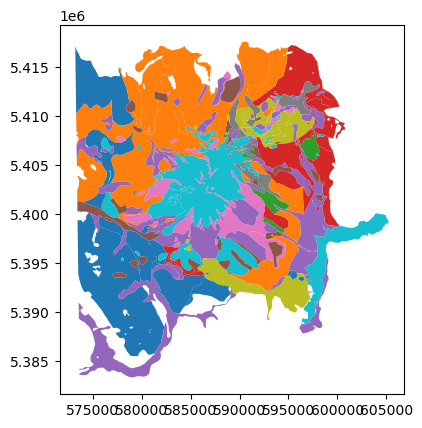

In [22]:
lithology_gdf.plot(column='GUNIT_LABE')

In [23]:
bareground_lithology_by_valley = bareground_polys_gdf.groupby("Valley Name").apply(lithology_gdf.clip).reset_index()
bareground_lithology_by_valley['AREA'] = bareground_lithology_by_valley.geometry.area
bareground_lithology_by_valley = bareground_lithology_by_valley.query("GUNIT_LABE != 'ice'")


erosion_lithology_by_valley = erosion_polygons_gdf.groupby('name').apply(lithology_gdf.clip).reset_index()

erosion_lithology_by_valley['AREA'] = erosion_lithology_by_valley.geometry.area
erosion_lithology_by_valley = erosion_lithology_by_valley.query("GUNIT_LABE != 'ice'")

create lithology dataset for each valley and combine datasets

In [24]:
# gunit_convert = {
#     'Qat': "Pleistocene,at,alpine glacial till,loose material",
#     'Qva(b)': "Holocene-Pleistocene,va,andesite flows,igneous",
#     'KJm(n1)': "Cretaceous-Jurassic,m,marine sedimentary rocks,sedimentary",
#     'Qad': "Pleistocene,ad,alpine glacial drift,loose material",
#     'Kigb': "Cretaceous,igb,gabbro,volcanic",
#     'JPMhmc(b)': "Jurassic-Permian,hmc,heterogeneous metamorphic rocks,metamorphic",
#     'Qvx(b)': "Quaternary,vx,volcanic breccia,volcanic",
#     'KJm(n2)': "Cretaceous-Jurassic,m,marine sedimentary rocks,sedimentary",
#     'Qls': "Quaternary,ls,mass-wasting deposits,loose material",
#     'Migd': "Miocene,igd,granodiorite,igneous",
#     'Qta': "Holocene-Pleistocene,ta,talus deposits,loose material",
#     'Qva(p)': "Quaternary,va,andesite flows,igneous",
#     'Qvt(ks)': "Pleistocene,vt,tuffs and tuff breccias,volcanic",
#     'KJm(n4)': "Cretaceous-Jurassic,m,marine sedimentary rocks,sedimentary",
#     'Qva(ld)': "Quaternary,va,andesite flows,igneous",
#     'PMvb(c)': "Permian,vb,basalt flows,igneous",
#     'Qva(bb)': "Quaternary,va,andesite flows,igneous",
# }

gunit_convert = {
    'Qat': "Pleistocene,at,alpine glacial till,Pleistocene glaciogenic material",
    'Qva(b)': "Holocene-Pleistocene,va,andesite flows,Igneous",
    'KJm(n1)': "Cretaceous-Jurassic,m,marine sedimentary rocks,Sedimentary",
    'Qad': "Pleistocene,ad,alpine glacial drift,Pleistocene glaciogenic material",
    'Kigb': "Cretaceous,igb,gabbro,Igneous",
    'JPMhmc(b)': "Jurassic-Permian,hmc,heterogeneous metamorphic rocks,Metamorphic",
    'Qvx(b)': "Quaternary,vx,volcanic breccia,Volcanic",
    'KJm(n2)': "Cretaceous-Jurassic,m,marine sedimentary rocks,Sedimentary",
    'Qls': "Quaternary,ls,mass-wasting deposits,Quaternary mass wasting deposits",
    'Migd': "Miocene,igd,granodiorite,Igneous",
    'Qta': "Holocene-Pleistocene,ta,talus deposits,Holocene-pleistocene talus",
    'Qva(p)': "Quaternary,va,andesite flows,Igneous",
    'Qvt(ks)': "Pleistocene,vt,tuffs and tuff breccias,Volcanic",
    'KJm(n4)': "Cretaceous-Jurassic,m,marine sedimentary rocks,Sedimentary",
    'Qva(ld)': "Quaternary,va,andesite flows,Igneous",
    'PMvb(c)': "Permian,vb,basalt flows,Igneous",
    'Qva(bb)': "Quaternary,va,andesite flows,Igneous",
}

In [25]:
bareground_lithology_by_valley['unit description'] = bareground_lithology_by_valley['GUNIT_LABE'].apply(gunit_convert.get)
bareground_lithology_by_valley['description'] = bareground_lithology_by_valley['unit description'].apply(lambda s: s.split(",")[-1])

erosion_lithology_by_valley['unit description'] = erosion_lithology_by_valley['GUNIT_LABE'].apply(gunit_convert.get)
erosion_lithology_by_valley['description'] = erosion_lithology_by_valley['unit description'].apply(lambda s: s.split(",")[-1])

### Plot proportion of each lithology by area in each valley

In [26]:
src = erosion_lithology_by_valley.copy()
# normalize area of of each unit by total area measured in each valley
src['AREA'] = src['AREA'] / src.groupby('name')['AREA'].transform('sum')

alt.Chart(src).mark_arc().encode(
    alt.Theta("AREA:Q"),
    alt.Color("unit description:N"),
    alt.Facet("name:N", columns=5)
).properties(width=100, height=100).configure_view(strokeWidth=0).configure_legend(labelLimit=0)

alt.Chart(...)

In [27]:
alt.Chart(
    pd.DataFrame(bareground_lithology_by_valley.groupby(['description', 'unit description'])['AREA'].sum()).reset_index()
).mark_bar().encode(
    alt.Y("unit description:N", sort='x', axis=alt.Axis(labelLimit=500, title='')),
    alt.X("AREA:Q", title='Area (m²)'),
    alt.Color("description:N")
).properties(
    title = 'Total area covered by surface lithology units in measured bareground area in 10 watersheds'
)

alt.Chart(...)

In [28]:
least_common_5_units = bareground_lithology_by_valley.groupby(['description', 'unit description'])['AREA'].sum().sort_values().reset_index()['unit description'].head(5)

least_common_5_units

0    Jurassic-Permian,hmc,heterogeneous metamorphic...
1                      Permian,vb,basalt flows,Igneous
2                        Cretaceous,igb,gabbro,Igneous
3      Pleistocene,vt,tuffs and tuff breccias,Volcanic
4                     Miocene,igd,granodiorite,Igneous
Name: unit description, dtype: object

In [29]:
src = bareground_lithology_by_valley.copy()

# REMOVE LEAST COMMON 5 UNITS
src = src[~src['unit description'].isin(least_common_5_units)]

# normalize area of of each unit by total area measured in each valley
src['AREA'] = src['AREA'] / src.groupby('Valley Name')['AREA'].transform('sum')

alt.Chart(src).mark_arc().encode(
    alt.Theta("AREA:Q"),
    alt.Color("unit description:N"),
    alt.Facet("Valley Name:N", columns=5)
).properties(
    width=100, height=100,
    title = 'Relative prevalence of surface lithology units in measured bareground area'
).configure_view(strokeWidth=0).configure_legend(labelLimit=0)

alt.Chart(...)

In [30]:
bareground_lithology_by_valley['description'].unique()
res = bareground_lithology_by_valley.groupby(["Valley Name", "description"])[['AREA']].sum()
denom = res.groupby('Valley Name')['AREA'].sum()
res['AREA'] = res['AREA'] / denom
res = res.reset_index()
alt.Chart(
    res
).mark_arc().encode(
    theta=alt.Theta(field="AREA", type="quantitative"),
    color=alt.Color(field="description", type="nominal"),
    facet=alt.Facet("Valley Name:N", columns=5),
    # groupby = "Valley Name:N"
).properties(width=100, height=100).configure_view(strokeWidth=0)

alt.Chart(...)

In [31]:
lithology_data =  res.copy()

## With process polygons

In [32]:
process_polys_gdf = gpd.GeoDataFrame(
    pd.read_csv("outputs/terrain_attributes_processpolygons.csv"),
    geometry = pd.read_csv("outputs/terrain_attributes_processpolygons.csv")['geometry'].apply(wkt.loads),
    crs='EPSG:32610'
)

In [33]:
process_polys_gdf.head(3)

,Unnamed: 0,area,name,type,geometry,process,ddem,dtm,drainage area,slope,aspect,curvature,ddem normalized
0,0,1936.007691,Coleman,gully,"POLYGON ((584300.897 5406297.566, 584289.115 5...",gully,-14.649569,1540.569458,96700.0,36.079900,208.515351,-2.894094,-0.007567
1,1,10770.435022,Mazama,gully,"POLYGON ((588485.224 5408358.069, 588494.063 5...",gully,-22.569996,1412.712280,592300.0,41.199639,95.941455,-2.497669,-0.002096
2,2,16692.431381,Mazama,gully,"POLYGON ((587157.956 5406946.962, 587157.379 5...",gully,-1.734620,1852.840698,121100.0,34.315297,111.993154,-1.009723,-0.000104


In [34]:
process_polys_gdf.geometry.type.unique()

array(['Polygon', 'MultiPolygon'], dtype=object)

In [35]:
def process_geometry(row):
    res = lithology_gdf.clip(row.geometry)
    res['AREA'] = res.geometry.area
    res['volume'] = res['AREA']*row['ddem']
    res['type'] = row['type']
    return res

results = process_polys_gdf.apply(process_geometry, axis=1)
lithology_by_process = pd.concat(list(results))
lithology_by_process = lithology_by_process.query("GUNIT_LABE != 'ice'")
lithology_by_process['unit description'] = lithology_by_process['GUNIT_LABE'].apply(gunit_convert.get)
lithology_by_process['description'] = lithology_by_process['unit description'].apply(lambda s: s.split(",")[-1])
lithology_by_process = lithology_by_process.reset_index()

GeometryTypeError: Unknown geometry type: 'featurecollection'

### Plot proportion of each lithology by eroded volume, organized by process typem

In [36]:
res = lithology_by_process.groupby(["type", "description"])[['volume']].sum()
denom = res.groupby('type')['volume'].sum()
res['volume'] = res['volume'] / denom
res = res.reset_index()
alt.Chart(
    res
).mark_arc().encode(
    theta=alt.Theta(field="volume", type="quantitative"),
    color=alt.Color(field="description", type="nominal"),
    facet=alt.Facet("type:N", columns=5),
    # groupby = "Valley Name:N"
).properties(width=100, height=100).configure_view(strokeWidth=0)

NameError: name 'lithology_by_process' is not defined

In [37]:
### Plot proportion of each lithology by area, organized by process type

In [38]:
res = lithology_by_process.groupby(["type", "description"])[['AREA']].sum()
denom = res.groupby('type')['AREA'].sum()
res['AREA'] = res['AREA'] / denom
res = res.reset_index()
alt.Chart(
    res
).mark_arc().encode(
    theta=alt.Theta(field="AREA", type="quantitative"),
    color=alt.Color(field="description", type="nominal"),
    facet=alt.Facet("type:N", columns=5),
    # groupby = "Valley Name:N"
).properties(width=100, height=100).configure_view(strokeWidth=0)

NameError: name 'lithology_by_process' is not defined

# Gross erosion/accumulation plots by process

In [39]:
bars = alt.Chart().mark_bar(
    strokeWidth = 2,
    stroke="white",
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y('Annual Mass Wasted'),
    alt.Color('type',
        scale=alt.Scale(
            domain=['negative', 'positive'],
            range=['#d62728', '#1f77b4']
        )
    )
)

error_bars = alt.Chart().mark_bar(
    color="black",
    width=2
).encode(
    alt.X('Average Date:T'),
    alt.Y("Lower CI", title=""),
    alt.Y2("Upper CI")
)

alt.layer(
    bars, 
    error_bars.transform_filter(alt.datum.type == 'negative'), 
    error_bars.transform_filter(alt.datum.type == 'positive'),
    data=gross_data_bytype_df.drop(columns=['index'])
).properties(
    height=200
).facet(
    row=alt.Row(
        'valley:N', 
        header=alt.Header(
            # labelOrient='top',
            labelFontWeight="bold", 
            labelPadding=0
        ),
        title="Annualized rate of volumetric change, in 1,000s of m³/yr"
    ),
    column=alt.Column("process:N"),
    spacing=1
).resolve_scale(
    y='independent'
)

alt.FacetChart(...)

In [40]:
from datetime import timedelta
gross_data_bytype_df['Average Date Plus'] = gross_data_bytype_df['Average Date'] + timedelta(days=120)
gross_data_bytype_df['Average Date Minus'] = gross_data_bytype_df['Average Date'] - timedelta(days=120)

In [41]:
bars = alt.Chart().mark_bar(
    strokeWidth = 2,
    stroke="white",
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y('Annual Mass Wasted'),
    alt.Color('type',
        scale=alt.Scale(
            domain=['negative', 'positive'],
            range=['#d62728', '#1f77b4']
        )
    )
)

error_bars = alt.Chart().encode(
    alt.X('Average Date:T'),
    alt.Y("Lower CI", title=""),
    alt.Y2("Upper CI")
)

alt.layer(
    bars, 
    error_bars.transform_filter(alt.datum.type == 'negative').mark_bar(color="black", width=2).encode(alt.X('Average Date Minus:T')), 
    error_bars.transform_filter(alt.datum.type == 'positive').mark_bar(color="black", width=2).encode(alt.X('Average Date Plus:T')),
    data=gross_data_bytype_df.drop(columns=['index'])
).properties(
    height=200
).facet(
    row=alt.Row(
        'valley:N', 
        header=alt.Header(
            # labelOrient='top',
            labelFontWeight="bold", 
            labelPadding=0
        ),
        title="Annualized rate of volumetric change, in 1,000s of m³/yr"
    ),
    column=alt.Column("process:N"),
    spacing=1
).resolve_scale(
    y='independent'
)

alt.FacetChart(...)

In [42]:
bars = alt.Chart().mark_bar(
    strokeWidth = 2,
    stroke="white",
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y('Annual Mass Wasted'),
    alt.Color('type',
        scale=alt.Scale(
            domain=['negative', 'positive'],
            range=['#d62728', '#1f77b4']
        )
    )
)

error_bars = alt.Chart().mark_bar(
    color="black",
    width=2
).encode(
    alt.X('Average Date:T'),
    alt.Y("Lower CI", title=""),
    alt.Y2("Upper CI")
)

layer = alt.layer(
    bars, 
    error_bars.transform_filter(alt.datum.type == 'negative'), 
    error_bars.transform_filter(alt.datum.type == 'positive'),
    data=gross_data_bytype_df.drop(columns=['index'])
).properties(
    height=100
).facet(
    row=alt.Row(
        'valley:N', 
        header=alt.Header(
            # labelOrient='top',
            labelFontWeight="bold", 
            # labelPadding=-10
        ),
        title="Annualized rate of volumetric change, in 1,000s of m³/yr"
    ),
    spacing=1
)

layer.transform_filter(
    alt.datum.process == 'fluvial'
).properties(title='fluvial') | layer.transform_filter(
    alt.datum.process == 'hillslope'
).properties(title='hillslope')

alt.HConcatChart(...)

# Valley slope plots

In [43]:
# Rainbow: 0 - 72
# Mazama: 0 - 63
# Deming: 0 - 69
# Coleman: 0 - ...
# Easton: 

In [44]:
df = elevation_df.query("valley == 'Rainbow'").query(
    "n_from_glacial_max > 0"
).query(
    "n_from_glacial_max < 72"
).sort_values(
    "n_from_glacial_max"
).query("time == '2015_09_01'")

np.degrees(np.arctan(
    (df.iloc[-1]['elevation'] - df.iloc[0]['elevation']) / (
        df.iloc[-1]['path_distance_from_glacier'] - df.iloc[0]['path_distance_from_glacier']
    )
))

-6.379613399476463

In [45]:
df = elevation_df.query("valley == 'Mazama'").query(
    "n_from_glacial_max > 0"
).query(
    "n_from_glacial_max < 63"
).sort_values(
    "n_from_glacial_max"
).query("time == '2015_09_01'")

np.degrees(np.arctan(
    (df.iloc[-1]['elevation'] - df.iloc[0]['elevation']) / (
        df.iloc[-1]['path_distance_from_glacier'] - df.iloc[0]['path_distance_from_glacier']
    )
))

-8.53070367579681

In [46]:
df = elevation_df.query("valley == 'Deming'").query(
    "n_from_glacial_max > 0"
).query(
    "n_from_glacial_max < 69"
).sort_values(
    "n_from_glacial_max"
).query("time == '2015_09_01'")

np.degrees(np.arctan(
    (df.iloc[-1]['elevation'] - df.iloc[0]['elevation']) / (
        df.iloc[-1]['path_distance_from_glacier'] - df.iloc[0]['path_distance_from_glacier']
    )
))

-6.412609773344338

In [47]:
df = elevation_df.query("valley == 'Coleman'").query(
    "n_from_glacial_max > 0"
).sort_values(
    "n_from_glacial_max"
).query("time == '2015_09_01'")

np.degrees(np.arctan(
    (df.iloc[-1]['elevation'] - df.iloc[0]['elevation']) / (
        df.iloc[-1]['path_distance_from_glacier'] - df.iloc[0]['path_distance_from_glacier']
    )
))

-7.197778333892654

In [48]:
alt.Chart(slope_halfkm_df).mark_line(point=True).encode(
    alt.X('time:T', title=""),
    alt.Y('slope:Q', title="Valley floor slope"),
    alt.Color("valley:N"),
    alt.Facet('Half kilometer downstream from glacier:O', title='Half kilometer downstream from glacier')
).properties(width=200)


alt.Chart(...)

In [49]:
alt.Chart(slope_km_df).mark_line(point=True).encode(
    alt.X('time:T', title=""),
    alt.Y('slope:Q', title="Valley floor slope"),
    alt.Color("valley:N"),
    alt.Facet('Kilometer downstream from glacier:O', title='Kilometer downstream from glacier')
).properties(width=200)

alt.Chart(...)

In [50]:
elevation_df.time.unique()

array(['1970_09_29', '1987_08_21', '1990_09_05', '2015_09_01',
       '1947_09_14', '1979_10_06', '1991_09_09', '1992_09_18',
       '1977_09_27', '1974_08_10'], dtype=object)

In [51]:
elevation_df[elevation_df['time'].isin(['1947_09_14', '1970_09_29', '1977_09_27', '1979_10_06', '2015_09_01'])].time.unique()

array(['1970_09_29', '2015_09_01', '1947_09_14', '1979_10_06',
       '1977_09_27'], dtype=object)

In [52]:
elevation_df.query("valley =='Rainbow'").time.unique()

array(['1970_09_29', '1947_09_14', '1977_09_27', '1974_08_10',
       '1991_09_09', '2015_09_01'], dtype=object)

In [53]:
elevation_df.query("valley =='Mazama'").time.unique()

array(['1970_09_29', '1992_09_18', '1947_09_14', '1979_10_06',
       '2015_09_01'], dtype=object)

In [54]:
elevation_df.query("valley =='Deming'").time.unique()

array(['1970_09_29', '1991_09_09', '1947_09_14', '1979_10_06',
       '2015_09_01'], dtype=object)

In [55]:
elevation_df = elevation_df[elevation_df['time'].isin(['1947_09_14', '1970_09_29', '1977_09_27', '1979_10_06', '2015_09_01'])]

In [56]:
elevation_df = elevation_df[elevation_df['time'].isin(['1947_09_14', '1970_09_29', '1977_09_27', '1979_10_06', '2015_09_01'])]
# elevation_df = elevation_df[~(
#     (elevation_df['time'] == '1979_10_06') & (elevation_df['valley'] == 'Rainbow')
# )]
# elevation_df = elevation_df[~(
#     (elevation_df['time'] == '1979_10_06') & (elevation_df['valley'] == 'Mazama')
# )]
elevation_df

,id,level_1,time,path_distance_from_glacier,elevation,glacial,n_from_glacial_max,valley
0,0,0,1970_09_29,1073.631648,NaN,False,89,Coleman
3,1,150,1970_09_29,1063.316179,NaN,False,88,Coleman
6,2,300,1970_09_29,1050.263060,NaN,False,87,Coleman
9,3,450,1970_09_29,1037.321554,NaN,False,86,Coleman
12,4,600,1970_09_29,1024.119654,NaN,False,85,Coleman
...,...,...,...,...,...,...,...,...
643,101,15176,1947_09_14,39.423398,1168.836304,False,2,Rainbow
644,102,15301,1947_09_14,22.854645,1173.924194,False,1,Rainbow
645,103,15452,1947_09_14,0.000000,1183.639038,False,0,Rainbow
646,104,15601,1947_09_14,-16.925409,1186.092163,False,-1,Rainbow


In [57]:
src = elevation_df[[ "time", "path_distance_from_glacier", "elevation", "glacial", "valley"]].reset_index()
alt.Chart(
    src
).mark_line(
    strokeWidth=1, clip=True
).transform_filter(
    {'field': 'valley', 'oneOf': ['Deming', 'Mazama', 'Rainbow']}
).transform_filter(
    alt.datum.glacial==False
).encode(
    alt.X(
        "path_distance_from_glacier:Q", 
        title="Distance downstream from observed glacial maximum", 
        scale=alt.Scale(domain=[-800, 1800])
    ),
    alt.Y(
        "elevation:Q", 
        scale=alt.Scale(domain=[950, 1200]), 
        title="Valley floor elevation, in meters"
    ),
    alt.StrokeDash("time:O", scale=alt.Scale(
            domain = ['1947_09_14', '1970_09_29', '1977_09_27', '1979_10_06', '2015_09_01'],
            range= [[6,1.5], [4, 2.5], [1, 2],[1, 2], [1, 0]]
        )
    ),
    alt.Color("valley:N"),
).properties(
    width = 500,
    height = 500,
    title='Elevation profile of main stream channel downstream of glaciers'
).configure_axis(grid=False)

alt.Chart(...)

In [58]:
src = elevation_df[[ "time", "path_distance_from_glacier", "elevation", "glacial", "valley"]].reset_index()
src.loc
src.loc[src.valley == 'Rainbow', 'elevation'] = src.loc[src.valley == 'Rainbow', 'elevation'] + 30
src.loc[src.valley == 'Deming', 'elevation'] = src.loc[src.valley == 'Deming', 'elevation'] + 10
alt.Chart(
    src
).mark_line(
    strokeWidth=1, clip=True
).transform_filter(
    {'field': 'valley', 'oneOf': ['Deming', 'Mazama', 'Rainbow']}
).transform_filter(
    alt.datum.glacial==False
).encode(
    alt.X(
        "path_distance_from_glacier:Q", 
        title="Distance downstream from observed glacial maximum", 
        scale=alt.Scale(domain=[-400, 1900])
    ),
    alt.Y(
        "elevation:Q", 
        scale=alt.Scale(domain=[950, 1200]), 
        title="Valley floor elevation, in meters"
    ),
    alt.StrokeDash("time:O", scale=alt.Scale(
            domain = ['1947_09_14', '1970_09_29', '1977_09_27', '1979_10_06', '2015_09_01'],
            range= [[8,1.5], [4, 2.5], [1, 2],[1, 2], [1, 0]]
        )
    ),
    alt.Color("valley:N"),
).properties(
    width = 1000,
    height = 500,
    title={
        "text":'Elevation profile of main stream channel downstream of glaciers',
        "subtitle": "Rainbow data shifted upwards 30 meters, Deming data shifted upwards 10 meters for clarity."
    }
).configure_axis(grid=False)

alt.Chart(...)

In [59]:
for date in [
    '2015_09_01',
    '1970_09_29',
    '1947_09_14'
]:
    rainbow_slope = src.query("valley == 'Rainbow'").query(f"time == '{date}'").query(
    "path_distance_from_glacier < 1200").query("path_distance_from_glacier > 0").sort_values("path_distance_from_glacier")

    print(np.degrees(np.arctan(
    (rainbow_slope['elevation'].iloc[-1] - rainbow_slope['elevation'].iloc[0]) / (
        rainbow_slope['path_distance_from_glacier'].iloc[-1] - rainbow_slope['path_distance_from_glacier'].iloc[0]
    )
    )))

-6.069261849706966
-5.839545003969226
-6.269839062519504


In [60]:
for date in [
    '2015_09_01',
    '1970_09_29',
    '1947_09_14'
]:
    mazama_slope = src.query("valley == 'Mazama'").query(f"time == '{date}'").query(
        "path_distance_from_glacier < 400").query("path_distance_from_glacier > 0").sort_values("path_distance_from_glacier")

    print(np.degrees(np.arctan(
    (mazama_slope['elevation'].iloc[-1] - mazama_slope['elevation'].iloc[0]) / (
        mazama_slope['path_distance_from_glacier'].iloc[-1] - mazama_slope['path_distance_from_glacier'].iloc[0]
    )
    )))

-9.998041217961076
-9.74519226544627
-9.611412939810151


In [61]:
for date in [
    '2015_09_01',
    '1979_10_06',
    '1970_09_29',
    '1947_09_14'
]:
    deming_slope = src.query("valley == 'Deming'").query(f"time == '{date}'").query(
        "path_distance_from_glacier < 1400").query("path_distance_from_glacier > 0").sort_values("path_distance_from_glacier")
    print(
    np.degrees(np.arctan(
    (deming_slope['elevation'].iloc[-1] - deming_slope['elevation'].iloc[0]) / (
        deming_slope['path_distance_from_glacier'].iloc[-1] - deming_slope['path_distance_from_glacier'].iloc[0]
    )
    )))

-5.8725268569524625
-6.330834807056336
nan
-6.262768292787924


# Cumulative net erosion plots by process

In [62]:
cum_process_df = pd.concat(
    [pd.read_pickle(f) for f in cum_process_files]
)

cum_process_df['cumulative volume'] = cum_process_df['cumulative volume']/1000
cum_process_df['Lower CI'] = cum_process_df['Lower CI']/1000
cum_process_df['Upper CI'] = cum_process_df['Upper CI']/1000

cum_process_df['type'] = cum_process_df['type'].apply(lambda existing_type: 'glacial' if existing_type == 'glacial debutressing' else existing_type)
cum_process_df['bounding'] = False

cum_process_df.head(3)

,dh,area,volume,type,n_pixels,volumetric_uncertainty,start_time,end_time,time_difference_years,Annual Mass Wasted,Upper CI,Lower CI,Average Date,cumulative volume,valley,bounding
0,-3.332537,22784.0,-75928.532410,fluvial,5696.0,23819.786864,1947-09-14,1970-09-29,23.0,-3301.240540,0.0,0.0,1959-03-23,-75.928532,Coleman,False
1,1.345391,6740.0,9067.937183,fluvial,1685.0,4540.893204,1970-09-29,1979-10-06,9.0,1007.548576,0.0,0.0,1975-04-03,-66.860595,Coleman,False
2,1.146770,6700.0,7683.362198,fluvial,1675.0,7167.023589,1979-10-06,1987-08-21,8.0,960.420275,0.0,0.0,1983-09-13,-59.177233,Coleman,False


In [63]:
cum_process_bounding_df = pd.concat(
    [pd.read_pickle(f) for f in cum_process_bounding_files]
)

cum_process_bounding_df['cumulative volume'] = cum_process_bounding_df['cumulative volume']/1000
cum_process_bounding_df['Lower CI'] = cum_process_bounding_df['Lower CI']/1000
cum_process_bounding_df['Upper CI'] = cum_process_bounding_df['Upper CI']/1000

cum_process_bounding_df['type'] = cum_process_bounding_df['type'].apply(lambda existing_type: 'glacial' if existing_type == 'glacial debutressing' else existing_type)

cum_process_bounding_df['bounding'] = True

cum_process_bounding_df = cum_process_bounding_df.dropna(subset='start_time')

cum_process_bounding_df.head(3)

,dh,area,volume,type,n_pixels,volumetric_uncertainty,start_time,end_time,time_difference_years,Annual Mass Wasted,Upper CI,Lower CI,Average Date,cumulative volume,valley,bounding
0,-2.738245,35904.0,-98313.948853,fluvial,8976.0,17971.714857,1947-09-14,2015-09-01,68.0,-1445.793365,-80.342234,-116.285664,1981-09-07,-98.313949,Coleman,True
1,-19.753988,39000.0,-770405.542374,glacial,9750.0,19440.288131,1947-09-14,2015-09-01,68.0,-11329.493270,-750.965254,-789.845831,1981-09-07,-770.405542,Coleman,True
2,-12.521563,1944.0,-24341.917648,gully,486.0,1635.568839,1947-09-14,2015-09-01,68.0,-357.969377,-22.706349,-25.977486,1981-09-07,-24.341918,Coleman,True


In [64]:
all_data = cum_and_bounding_cum_w_largerarea_df.query("~bounding").query("~larger_area").query("valley != 'Easton'")[['valley', 'end_time','cumulative volume','Lower CI','Upper CI']]
all_data['type'] = 'all'
bytype_data = cum_process_df.query("valley != 'Easton'")
bytype_bounding_data = cum_process_bounding_df.query("valley != 'Easton'")

In [65]:
cum_data_alltogether = pd.concat([bytype_data, bytype_bounding_data, all_data])[['valley', 'start_time', 'end_time','cumulative volume','type','Lower CI','Upper CI', 'bounding', 'Annual Mass Wasted']]

In [66]:
cum_plot = alt.Chart().mark_line(point=True).encode(
    alt.X('end_time:T', title='Time'),
    alt.Y('cumulative volume:Q'),
)

error_bars = alt.Chart().mark_bar(
    width=2
).encode(
    alt.X("end_time:T"),
    alt.Y("Lower CI", title="Cumulative net change, in 1,000s of m³/yr"),
    alt.Y2("Upper CI")
)

simple_cum_chart = alt.layer(
    cum_plot.transform_filter((alt.datum.bounding == False) & (alt.datum.larger_area == False)),
    error_bars.transform_filter((alt.datum.bounding == False) & (alt.datum.larger_area == False)),
    data=cum_and_bounding_cum_w_largerarea_df.drop(columns='index')
).properties(
    width=300, height=100
).facet(
    column=alt.Column(
        'valley:N', 
        header=alt.Header(
            labelOrient='top',
            labelFontWeight="bold",
            # labelPadding=-10
        ),
        title="Cumulative net change, in 1,000s of m³/yr",
        
    ),
    # spacing=1
).resolve_scale(
    y='independent'
)

simple_cum_chart

alt.FacetChart(...)

In [67]:
src = cum_and_bounding_cum_w_largerarea_df.drop(columns='index')
src = src[src['Upper CI'] != 0].query("bounding == False")
src = src.dropna()
src

,dh,area,volume,n_pixels,volumetric_uncertainty,start_time,end_time,time_difference_years,Annual Mass Wasted,Upper CI,Lower CI,Average Date,cumulative volume,valley,bounding,larger_area
4,-0.908247,327764.0,-297.690765,81941.0,76534.579830,1990-09-05,2015-09-01,25.0,-11907.630617,-629.418698,-1764.365283,2003-03-05,-1196.891991,Coleman,False,False
3,-3.329522,432756.0,-1440.870577,108189.0,78510.418525,1991-09-09,2015-09-01,24.0,-60036.274040,-3023.416087,-3556.619343,2003-09-05,-3290.017715,Deming,False,False
3,-0.971877,812444.0,-789.595427,203111.0,144582.992347,1992-09-18,2015-09-01,23.0,-34330.235936,-1614.175694,-3444.007335,2004-03-11,-2529.091514,Mazama,False,False
4,-0.558952,645616.0,-360.868415,161404.0,42969.409202,1991-09-09,2015-09-01,24.0,-15036.183940,-2006.979189,-2859.433839,2003-09-05,-2433.206514,Rainbow,False,False
1,-1.829480,421564.0,-771.242778,105391.0,75238.730561,1979-10-06,2015-09-01,36.0,-21423.410497,-2566.064190,-3166.096852,1997-09-18,-2866.080521,Deming,False,True
1,-1.617672,277020.0,-448.127620,69255.0,71039.465266,1979-10-06,2015-09-01,36.0,-12447.989452,-1654.084449,-1813.193002,1997-09-18,-1733.638725,Coleman,False,True
1,-1.468827,936920.0,-1376.173848,234230.0,192580.313311,1979-10-06,2015-09-01,36.0,-38227.051339,-1808.278056,-3745.507175,1997-09-18,-2776.892616,Mazama,False,True
1,-0.866479,669836.0,-580.398894,167459.0,6133.574464,1977-09-27,2015-09-01,38.0,-15273.655095,-1546.887829,-2555.859827,1996-09-14,-2051.373828,Rainbow,False,True


In [68]:



src = cum_and_bounding_cum_w_largerarea_df.drop(columns='index')
src['cumulative volume'] = - src['cumulative volume']/1000

# domain = ["1940-01-01", "2020-01-01"]
domain = ["1940", "2020"]

cum_plot = alt.Chart().mark_line().encode(
    # alt.X('end_time:T', title='Time', timeUnit='yearmonthdate', scale=alt.Scale(domain=domain)),
    alt.X('end_time:T', title='Time', timeUnit='year', scale=alt.Scale(domain=domain)),
    alt.Y('cumulative volume:Q'),
    alt.Color('valley:N')
)

error_bars = alt.Chart().mark_bar(
    width=2
).encode(
    alt.X("end_time:T"),
    alt.Y("Lower CI", title="Cumulative net change, in 1,000s of m³/yr"),
    # alt.Color('valley:N')
)

simple_cum_chart = alt.layer(
    cum_plot.transform_filter((alt.datum.bounding == False) & (alt.datum.larger_area == False)),
    # error_bars.transform_filter((alt.datum.bounding == False) & (alt.datum.larger_area == False)),
    data=src
).properties(
    width=350, height=200
)

simple_cum_chart

alt.LayerChart(...)

In [69]:
# scale=alt.Scale(domain=['fluvial', 'hillslope', 'all'], range=['#1f77b4', '#ff7f0e', '#d62728'])

src = gross_data_bytype_df.drop(columns=['index'])
src = src.query("valley != 'Easton'")
# src = src.query("valley != 'Coleman'")

src['Annual Mass Wasted'] = src['Annual Mass Wasted'].apply(lambda x: 1 if x == 0 else x)
src['Upper CI'] = src['Upper CI'].apply(lambda x: 1 if x == 0 else x)
src['Lower CI'] = src['Lower CI'].apply(lambda x: 1 if x == 0 else x)

src['Annual Mass Wasted'] = - src['Annual Mass Wasted']
src['Upper CI'] = - src['Upper CI']
src['Lower CI'] = - src['Lower CI']

bars_neg = alt.Chart().mark_bar(
    strokeWidth = 2,
    stroke="white",
).encode(
    alt.X('start_time:T', axis=alt.Axis(labels=False), title=None),
    alt.X2('end_time:T'),
    alt.Y('Annual Mass Wasted', scale=alt.Scale(domain=[-50,100], nice=False)),
    alt.Color("valley:N")
)

bars_pos = alt.Chart().mark_bar(
    strokeWidth = 2,
    stroke="white",
    opacity=0.5
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y('Annual Mass Wasted'),
    alt.Color("valley:N")

)

error_bars = alt.Chart().mark_bar(
    color="black",
    width=2
).encode(
    alt.X('Average Date:T'),
    alt.Y("Lower CI", title=[
        # "Annualized rate of volumetric change,", "in 1,000s of m³/yr"
        ]),
    alt.Y2("Upper CI")
)

hillslope_combo_gross_bars_chart = alt.layer(
    bars_neg.transform_filter(alt.datum.type == 'negative').transform_filter(alt.datum.process == 'hillslope'), 
    bars_pos.transform_filter(alt.datum.type == 'positive').transform_filter(alt.datum.process == 'hillslope'), 
    error_bars.transform_filter(alt.datum.type == 'negative').transform_filter(alt.datum.process == 'hillslope'), 
    error_bars.transform_filter(alt.datum.type == 'positive').transform_filter(alt.datum.process == 'hillslope'),
    data=src
).properties(
    width=350,
    height=150
).facet(
    row=alt.Column(
        'valley:N', 
        header=alt.Header(
            labels=False,
            labelFontSize=16
            # labelOrient='top',
            # labelFontWeight="bold", 
            # labelPadding=0
        ),
        title=None
    ),
    # spacing=1
)

hillslope_combo_gross_bars_chart

alt.FacetChart(...)

In [70]:
# (hillslope_combo_gross_bars_chart.transform_filter(alt.datum.valley != 'Coleman') & simple_cum_chart).configure_legend(
(hillslope_combo_gross_bars_chart.transform_filter(alt.datum.valley != 'Coleman').transform_filter(alt.datum.valley != 'Rainbow')
 & simple_cum_chart).configure_legend(
    titleFontSize=18, 
    labelFontSize=18, 
    orient='top', 
    symbolSize=1000, 
    symbolStrokeWidth=2
).configure_axis(
    labelFontSize=18, 
    titleFontSize=18,
).resolve_scale(
    x='shared'
)

alt.VConcatChart(...)

In [71]:
from datetime import timedelta

In [72]:
cum_data_alltogether.loc[cum_data_alltogether['bounding'] == True, 'end_time'] = cum_data_alltogether.loc[cum_data_alltogether['bounding'] == True, 'end_time'].apply(lambda date: date + timedelta(days=1000))

In [73]:
cum_data_alltogether.loc[cum_data_alltogether["type"] == 'all', 'bounding'] = False

In [84]:
src = cum_data_alltogether
src = src.query("valley != 'Easton'")
part1 = src[~src['type'].isin(['gully', 'mass wasting'])]
part2 = src[src['type'].isin(['gully', 'mass wasting'])].groupby(['valley', 'start_time', 'end_time', 'bounding']).sum().reset_index().assign(type='not glacial')
src = pd.concat([part1, part2])

src = src.append(pd.DataFrame({
    'valley': ['Coleman', 'Deming', 'Mazama', 'Rainbow'],
    'end_time': [datetime(1947, 9, 14), datetime(1947, 9, 14), datetime(1947, 9, 14), datetime(1947, 9, 14)],
    'cumulative volume': [0,0,0,0],
    'bounding': [False, False, False, False],
    'type': ['not glacial', 'not glacial', 'not glacial', 'not glacial']
}))

cum_plot = alt.Chart().mark_line(
    point={'size':20},
     strokeWidth=2.5,
).encode(
    alt.X('end_time:T', title='Time'),
    alt.Y('cumulative volume:Q', 
        scale=alt.Scale(domain=[-4000, 500])
    ),
    # alt.Color("type:N")
    alt.Color(
        "type:N", 
        scale=alt.Scale(domain=['fluvial', 'hillslope', 'all', 'glacial', 'not glacial'], range=['#1f77b4', '#d62728', '#000000', '#17becf', '#2ca02c'])
    ),
    alt.StrokeDash("type:N")
)

error_bars = alt.Chart().mark_bar(
    width=2
).encode(
    alt.X("end_time:T"),
    alt.Y("Lower CI", ),
    alt.Y2("Upper CI"),
    alt.Color(
        "type:N", 
        scale=alt.Scale(domain=['fluvial', 'hillslope', 'all', 'glacial', 'not glacial'], range=['#1f77b4', '#d62728', '#000000', '#17becf', '#2ca02c'])
    )
)


cumulative_by_process_chart_no_glacial = alt.layer(
    cum_plot.transform_filter(alt.FieldOneOfPredicate(field='type', oneOf=['all', 'fluvial', 'hillslope'])).transform_filter(alt.datum.bounding == False),
    error_bars.transform_filter(alt.FieldOneOfPredicate(field='type', oneOf=['all', 'fluvial', 'hillslope'])).transform_filter(alt.datum.bounding == False),
    # cum_plot2.transform_filter(alt.FieldOneOfPredicate(field='type', oneOf=['not glacial', 'glacial'])).transform_filter(alt.datum.bounding == False),
    # error_bars2.transform_filter(alt.FieldOneOfPredicate(field='type', oneOf=['not glacial', 'glacial'])).transform_filter(alt.datum.bounding == False),
    # bounding_points.transform_filter(alt.FieldOneOfPredicate(field='type', oneOf=['fluvial', 'hillslope', 'all'])).transform_filter(alt.datum.bounding == True),
    # bounding_points2.transform_filter(alt.datum.type == 'glacial').transform_filter(alt.datum.bounding == True),
    data=src
).properties(
    width=350
).facet(
    column=alt.Column('valley:N', header=alt.Header(labels=False, labelFontSize=16), title=''),
)
cumulative_by_process_chart_no_glacial

/tmp/ipykernel_105335/2072286382.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  part2 = src[src['type'].isin(['gully', 'mass wasting'])].groupby(['valley', 'start_time', 'end_time', 'bounding']).sum().reset_index().assign(type='not glacial')
/tmp/ipykernel_105335/2072286382.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  src = src.append(pd.DataFrame({
/tmp/ipykernel_105335/2072286382.py:7: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  src = src.append(pd.DataFrame({


alt.FacetChart(...)

In [75]:
src = cum_data_alltogether
src = src.query("valley != 'Easton'")
part1 = src[~src['type'].isin(['gully', 'mass wasting'])]
part2 = src[src['type'].isin(['gully', 'mass wasting'])].groupby(['valley', 'start_time', 'end_time', 'bounding']).sum().reset_index().assign(type='not glacial')
src = pd.concat([part1, part2])

src = src.append(pd.DataFrame({
    'valley': ['Coleman', 'Deming', 'Mazama', 'Rainbow'],
    'end_time': [datetime(1947, 9, 14), datetime(1947, 9, 14), datetime(1947, 9, 14), datetime(1947, 9, 14)],
    'cumulative volume': [0,0,0,0],
    'bounding': [False, False, False, False],
    'type': ['not glacial', 'not glacial', 'not glacial', 'not glacial']
}))

cum_plot = alt.Chart().mark_line(
        point={'size':20},
     strokeWidth=2.5,
).encode(
    alt.X('end_time:T', title='Time'),
    alt.Y('cumulative volume:Q', 
        scale=alt.Scale(domain=[-4000, 500])
    ),
    # alt.Color("type:N")
    alt.Color(
        "type:N", 
        scale=alt.Scale(domain=['fluvial', 'hillslope', 'all', 'glacial', 'not glacial'], range=['#1f77b4', '#d62728', '#000000', '#17becf', '#2ca02c'])
    )
)

error_bars = alt.Chart().mark_bar(
    width=2
).encode(
    alt.X("end_time:T"),
    alt.Y("Lower CI", ),
    alt.Y2("Upper CI"),
    alt.Color(
        "type:N", 
        scale=alt.Scale(domain=['fluvial', 'hillslope', 'all', 'glacial', 'not glacial'], range=['#1f77b4', '#d62728', '#000000', '#17becf', '#2ca02c'])
    )
)

cum_plot2 = alt.Chart().mark_line(
    # color='black', 
    strokeWidth=2.5, 
    strokeDash=[7, 7]
    # point={'size':20, 'color': 'black'}
).encode(
    alt.X('end_time:T', title='Time'),
    alt.Y('cumulative volume:Q', 
        # scale=alt.Scale(domain=[-5000, 1000])
    ),
    alt.Color(
        "type:N",
    )
)

error_bars2 = alt.Chart().mark_bar(
    width=2,
    # color='black'
).encode(
    alt.X("end_time:T"),
    alt.Y("Lower CI", title=["Cumulative net volumetric change", "(10³ m³/yr)"]),
    alt.Y2("Upper CI"),
    alt.Color(
        "type:N",
    )
)

bounding_points = alt.Chart().mark_circle(size=100, ).encode(
    alt.X("end_time:T"),
    alt.Y("cumulative volume:Q"),
    alt.Color(
        "type:N", 
        scale=alt.Scale(domain=['fluvial', 'hillslope', 'all', 'glacial', 'not glacial'], range=['#1f77b4', '#d62728', '#000000', '#17becf', '#2ca02c'])
    )
)

bounding_points2 = alt.Chart().mark_circle(size=100, color='#17becf').encode(
    alt.X("end_time:T"),
    alt.Y("cumulative volume:Q")
)

cumulative_by_process_chart = alt.layer(
    cum_plot.transform_filter(alt.FieldOneOfPredicate(field='type', oneOf=['all', 'fluvial', 'hillslope'])).transform_filter(alt.datum.bounding == False),
    error_bars.transform_filter(alt.FieldOneOfPredicate(field='type', oneOf=['all', 'fluvial', 'hillslope'])).transform_filter(alt.datum.bounding == False),
    cum_plot2.transform_filter(alt.FieldOneOfPredicate(field='type', oneOf=['not glacial', 'glacial'])).transform_filter(alt.datum.bounding == False),
    error_bars2.transform_filter(alt.FieldOneOfPredicate(field='type', oneOf=['not glacial', 'glacial'])).transform_filter(alt.datum.bounding == False),
    # bounding_points.transform_filter(alt.FieldOneOfPredicate(field='type', oneOf=['fluvial', 'hillslope', 'all'])).transform_filter(alt.datum.bounding == True),
    bounding_points2.transform_filter(alt.datum.type == 'glacial').transform_filter(alt.datum.bounding == True),
    data=src
).properties(
    width=350
).facet(
    column=alt.Column('valley:N', header=alt.Header(labels=False, labelFontSize=16), title=''),
)
cumulative_by_process_chart

/tmp/ipykernel_105335/2063266815.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  part2 = src[src['type'].isin(['gully', 'mass wasting'])].groupby(['valley', 'start_time', 'end_time', 'bounding']).sum().reset_index().assign(type='not glacial')
/tmp/ipykernel_105335/2063266815.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  src = src.append(pd.DataFrame({
/tmp/ipykernel_105335/2063266815.py:7: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  src = src.append(pd.DataFrame({


alt.FacetChart(...)

In [76]:
src.to_csv('outputs/final_figures_data/time_series_cumulative.csv')

In [77]:
src = cum_data_alltogether
src = src.query("valley != 'Easton'")
part1 = src[~src['type'].isin(['gully', 'mass wasting'])]
part2 = src[src['type'].isin(['gully', 'mass wasting'])].groupby(['valley', 'start_time', 'end_time', 'bounding']).sum().reset_index().assign(type='not glacial')
src = pd.concat([part1, part2])

src = src.append(pd.DataFrame({
    'valley': ['Coleman', 'Deming', 'Mazama', 'Rainbow'],
    'end_time': [datetime(1947, 9, 14), datetime(1947, 9, 14), datetime(1947, 9, 14), datetime(1947, 9, 14)],
    'cumulative volume': [0,0,0,0],
    'bounding': [False, False, False, False],
    'type': ['not glacial', 'not glacial', 'not glacial', 'not glacial']
}))

cum_plot = alt.Chart().mark_line(
     strokeWidth=2.5,
).encode(
    alt.X('end_time:T', title='Time'),
    alt.Y('cumulative volume:Q', 
        scale=alt.Scale(domain=[-4000, 500])
    ),
    # alt.Color("type:N")
    alt.Color(
        "type:N", 
        scale=alt.Scale(domain=['fluvial', 'hillslope', 'all', 'glacial', 'not glacial'], range=['#1f77b4', '#d62728', '#000000', '#17becf', '#2ca02c'])
    )
)

cum_plot2 = alt.Chart().mark_line(
    # color='black', 
    strokeWidth=2.5, 
    strokeDash=[7, 7]

).encode(
    alt.X('end_time:T', title='Time'),
    alt.Y('cumulative volume:Q', 
        # scale=alt.Scale(domain=[-5000, 1000])
    ),
    alt.Color(
        "type:N",
    )
)



alt.layer(
    cum_plot.transform_filter(alt.FieldOneOfPredicate(field='type', oneOf=['all', 'fluvial', 'hillslope'])).transform_filter(alt.datum.bounding == False),
    
    cum_plot2.transform_filter(alt.FieldOneOfPredicate(field='type', oneOf=['not glacial', 'glacial'])).transform_filter(alt.datum.bounding == False),
    
    data=src
).properties(
    width=350
).facet(
    column=alt.Column('valley:N', header=alt.Header(labels=False, labelFontSize=16), title=''),
).configure_legend(
    titleFontSize=16, 
    labelFontSize=14, 
    orient='top', 
    symbolSize=1000, 
    symbolStrokeWidth=2
)

/tmp/ipykernel_105335/1813725691.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  part2 = src[src['type'].isin(['gully', 'mass wasting'])].groupby(['valley', 'start_time', 'end_time', 'bounding']).sum().reset_index().assign(type='not glacial')
/tmp/ipykernel_105335/1813725691.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  src = src.append(pd.DataFrame({
/tmp/ipykernel_105335/1813725691.py:7: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  src = src.append(pd.DataFrame({


alt.FacetChart(...)

In [78]:
src = cum_data_alltogether
src = src.query("valley != 'Easton'")
# src = src.query("valley != 'Coleman'")


cum_plot = alt.Chart().mark_line(
        point={'size':20},
     strokeWidth=2.5,
).encode(
    alt.X('end_time:T', title='Time'),
    alt.Y('cumulative volume:Q', 
        # scale=alt.Scale(domain=[-4000, 500])
    ),
    # alt.Color("type:N")
    alt.Color("valley:N")
)

error_bars = alt.Chart().mark_bar(
    width=2
).encode(
    alt.X("end_time:T"),
    alt.Y("Lower CI", title="Cumulative net change, in 1,000s of m³/yr"),
    alt.Y2("Upper CI"),
    alt.Color("valley:N")
)


cumulative_process_facet_valley_color = alt.layer(
    cum_plot.transform_filter(alt.datum.bounding == False),
    error_bars.transform_filter(alt.datum.bounding == False),
    data=src
).properties(
    width=350
).facet(
    column=alt.Column('type:N', 
    header=alt.Header(labelFontSize=16), title=''),
).resolve_scale(y='independent')
cumulative_process_facet_valley_color

alt.FacetChart(...)

In [86]:
src = gross_data_bytype_df.drop(columns=['index'])
src = src.query("valley != 'Easton'")
# src = src.query("valley != 'Coleman'")

src['Annual Mass Wasted'] = src['Annual Mass Wasted'].apply(lambda x: 1 if x == 0 else x)
src['Upper CI'] = src['Upper CI'].apply(lambda x: 1 if x == 0 else x)
src['Lower CI'] = src['Lower CI'].apply(lambda x: 1 if x == 0 else x)

bars_neg = alt.Chart().mark_bar(
    strokeWidth = 2,
    stroke="white",
    color='#1f77b4'
).encode(
    alt.X('start_time:T', axis=alt.Axis(labels=False), title=None),
    alt.X2('end_time:T'),
    alt.Y('Annual Mass Wasted'),
)

bars_pos = alt.Chart().mark_bar(
    strokeWidth = 2,
    stroke="white",
    color='#1f77b4',
    opacity=0.3
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y('Annual Mass Wasted'),
)

error_bars = alt.Chart().mark_bar(
    color="black",
    width=2
).encode(
    alt.X('Average Date:T'),
    alt.Y("Lower CI", title=["Annual volumetric change", "(10³ m³/yr)"]),
    alt.Y2("Upper CI")
)

fluvial_combo_gross_bars_chart = alt.layer(
    bars_neg.transform_filter(alt.datum.type == 'negative').transform_filter(alt.datum.process == 'fluvial'), 
    bars_pos.transform_filter(alt.datum.type == 'positive').transform_filter(alt.datum.process == 'fluvial'), 
    error_bars.transform_filter(alt.datum.type == 'negative').transform_filter(alt.datum.process == 'fluvial'), 
    error_bars.transform_filter(alt.datum.type == 'positive').transform_filter(alt.datum.process == 'fluvial'),
    data=src
).properties(
    width=350,
    height=200
).facet(
    column=alt.Column(
        'valley:N', 
        header=alt.Header(
            labelFontSize=24
            # labelOrient='top',
            # labelFontWeight="bold", 
            # labelPadding=0
        ),
        title=None
    ),
    # spacing=1
)
fluvial_combo_gross_bars_chart 

alt.FacetChart(...)

In [88]:
# scale=alt.Scale(domain=['fluvial', 'hillslope', 'all'], range=['#1f77b4', '#ff7f0e', '#d62728'])

src = gross_data_bytype_df.drop(columns=['index'])
src = src.query("valley != 'Easton'")
# src = src.query("valley != 'Coleman'")

src['Annual Mass Wasted'] = src['Annual Mass Wasted'].apply(lambda x: 1 if x == 0 else x)
src['Upper CI'] = src['Upper CI'].apply(lambda x: 1 if x == 0 else x)
src['Lower CI'] = src['Lower CI'].apply(lambda x: 1 if x == 0 else x)

bars_neg = alt.Chart().mark_bar(
    strokeWidth = 2,
    stroke="white",
    color='#d62728'
).encode(
    alt.X('start_time:T', axis=alt.Axis(labels=False), title=None),
    alt.X2('end_time:T'),
    alt.Y('Annual Mass Wasted'),
)

bars_pos = alt.Chart().mark_bar(
    strokeWidth = 2,
    stroke="white",
    color='#d62728',
    opacity=0.3
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y('Annual Mass Wasted'),
)

error_bars = alt.Chart().mark_bar(
    color="black",
    width=2
).encode(
    alt.X('Average Date:T'),
    alt.Y("Lower CI", title=[
        # "Annualized rate of volumetric change,", "in 1,000s of m³/yr"
        ]),
    alt.Y2("Upper CI")
)

hillslope_combo_gross_bars_chart = alt.layer(
    bars_neg.transform_filter(alt.datum.type == 'negative').transform_filter(alt.datum.process == 'hillslope'), 
    bars_pos.transform_filter(alt.datum.type == 'positive').transform_filter(alt.datum.process == 'hillslope'), 
    error_bars.transform_filter(alt.datum.type == 'negative').transform_filter(alt.datum.process == 'hillslope'), 
    error_bars.transform_filter(alt.datum.type == 'positive').transform_filter(alt.datum.process == 'hillslope'),
    data=src
).properties(
    width=350,
    height=200
).facet(
    column=alt.Column(
        'valley:N', 
        header=alt.Header(
            labels=False,
            labelFontSize=16
            # labelOrient='top',
            # labelFontWeight="bold", 
            # labelPadding=0
        ),
        title=None
    ),
    # spacing=1
)

hillslope_combo_gross_bars_chart

alt.FacetChart(...)

In [89]:
(
    fluvial_combo_gross_bars_chart & hillslope_combo_gross_bars_chart & cumulative_by_process_chart
).configure_legend(
    titleFontSize=16, 
    labelFontSize=14, 
    orient='top', 
    symbolSize=1000, 
    symbolStrokeWidth=2
).configure_axis(
    labelFontSize=24, 
    titleFontSize=24
).resolve_scale(
    x='shared'
)

alt.VConcatChart(...)

In [90]:
(
    fluvial_combo_gross_bars_chart & hillslope_combo_gross_bars_chart & cumulative_by_process_chart_no_glacial
).configure_legend(
    titleFontSize=16, 
    labelFontSize=14, 
    orient='top', 
    symbolSize=1000, 
    symbolStrokeWidth=2
).configure_axis(
    labelFontSize=24, 
    titleFontSize=24
).resolve_scale(
    x='shared'
)

alt.VConcatChart(...)

In [80]:
src = cum_data_alltogether
src = src.query("valley != 'Easton'")
# src = src.query("valley != 'Coleman'")
src.head()

,valley,start_time,end_time,cumulative volume,type,Lower CI,Upper CI,bounding,Annual Mass Wasted
0,Coleman,1947-09-14,1970-09-29,-75.928532,fluvial,0.000000,0.000000,False,-3301.240540
1,Coleman,1970-09-29,1979-10-06,-66.860595,fluvial,0.000000,0.000000,False,1007.548576
2,Coleman,1979-10-06,1987-08-21,-59.177233,fluvial,0.000000,0.000000,False,960.420275
3,Coleman,1987-08-21,1990-09-05,-51.640309,fluvial,0.000000,0.000000,False,2512.307883
4,Coleman,1990-09-05,2015-09-01,-113.013662,fluvial,-149.899001,-76.128322,False,-2454.934095


In [81]:
src.type.unique()

array(['fluvial', 'glacial', 'gully', 'hillslope', 'mass wasting', 'all'],
      dtype=object)

In [82]:
def type_chart(
    src, 
    type, 
    x_axis=alt.Axis(), 
    facet_column=alt.Column('valley:N')
):
    return alt.Chart(src).transform_filter(
        alt.datum.bounding == False
    ).transform_filter(
        alt.datum.type == type
    ).mark_bar(
        strokeWidth = 2,
        stroke="white"
    ).encode(
        alt.X('start_time:T', axis=x_axis),
        alt.X2('end_time:T'),
        alt.Y('Annual Mass Wasted')
    ).properties(
        height=175
    ).facet(
        column=facet_column
    )

In [83]:
alt_col = alt.Column('valley:N', title=None, header=alt.Header(labels=False))
alt.vconcat(
    type_chart(src.sample(src.shape[0]), 'hillslope', x_axis=None),
    type_chart(src.sample(src.shape[0]), 'fluvial', x_axis=None, facet_column=alt_col),
    type_chart(src.sample(src.shape[0]), 'mass wasting', x_axis=None, facet_column=alt_col),
    type_chart(src.sample(src.shape[0]), 'gully', x_axis=None, facet_column=alt_col),
    type_chart(src.sample(src.shape[0]), 'glacial', facet_column=alt_col),
).resolve_scale(x='shared')




alt.VConcatChart(...)

In [84]:
src_bar = cum_data_alltogether.query("bounding == True")
src_bar = src_bar[src_bar['type'].isin(['glacial', 'gully', 'mass wasting'])]
src_bar = src_bar.groupby("type").sum().reset_index()
src_bar['cumulative volume'] = - src_bar['cumulative volume']


/tmp/ipykernel_374969/816738772.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  src_bar = src_bar.groupby("type").sum().reset_index()


In [85]:
src_bar

,type,cumulative volume,Lower CI,Upper CI,Annual Mass Wasted
0,glacial,2906.310398,-3042.309935,-2770.310862,-42739.858799
1,gully,1746.689647,-1866.812345,-1626.566948,-25686.612451
2,mass wasting,3000.647591,-3177.982925,-2823.312256,-44127.170450


In [86]:
alt.Chart(
    src_bar
).mark_bar().encode(
    alt.X('type:N', axis=alt.Axis(labelAngle=0)),
    alt.Y("cumulative volume:Q", axis=alt.Axis(tickCount=5), title='Total volumetric change (1,000s m³/yr)')
).properties(width=600, height=400).configure_legend(
    titleFontSize=16, 
    labelFontSize=14, 
    orient='top', 
    symbolSize=1000, 
    symbolStrokeWidth=2
).configure_axis(
    labelFontSize=24, 
    titleFontSize=16
).display(renderer='svg')

alt.Chart(...)

In [87]:
src_bar

,type,cumulative volume,Lower CI,Upper CI,Annual Mass Wasted
0,glacial,2906.310398,-3042.309935,-2770.310862,-42739.858799
1,gully,1746.689647,-1866.812345,-1626.566948,-25686.612451
2,mass wasting,3000.647591,-3177.982925,-2823.312256,-44127.170450


In [88]:
src_bar['is_glacial'] = src_bar['type'] == 'glacial'
alt.Chart(
    src_bar
).mark_bar().encode(
    alt.X('is_glacial:N'),
    alt.Color("type:N", ),
    alt.Y("cumulative volume:Q", axis=alt.Axis(tickCount=5))
).properties(width=600, height=400).configure_legend(
    titleFontSize=16, 
    labelFontSize=14, 
    orient='top', 
    symbolSize=1000, 
    symbolStrokeWidth=2
).configure_axis(
    labelFontSize=24, 
    titleFontSize=16
).display(renderer='svg')

alt.Chart(...)

In [89]:
yield_df = pd.read_csv("/data2/elilouis/yield_table.csv")

In [90]:
yield_df.head(3)

,total_load_percentage,streambank_percentage_lower_bound,streambank_percentage_upper_bound,proglacial_percentage_upper_bound,fork
0,100.0,0.0,26.0,10.0,North Fork
1,100.0,0.0,54.0,17.0,Middle Fork
2,100.0,10.0,30.0,16.0,Main Stem


## Save data

In [91]:
gross_data_bytype_df[[
    'Annual Mass Wasted',
    'Upper CI',
    'Lower CI',
    'start_time',
    'end_time',
    'Average Date',
    "process",
    "type",
    "valley",
]].to_csv('outputs/final_figures_data/time_series_annualized_gross.csv')

### Save lithology data for igneous-fraction

In [92]:
lithology_data = lithology_data.query("description != 'Igneous'")
lithology_data = lithology_data.groupby("Valley Name").sum().reset_index()
lithology_data

/tmp/ipykernel_374969/643769492.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  lithology_data = lithology_data.groupby("Valley Name").sum().reset_index()


,Valley Name,AREA
0,Boulder,0.323432
1,Coleman,0.778584
2,Deming,1.000000
3,Easton,0.999963
4,Mazama,0.885783
5,Park,0.698900
6,Rainbow,0.979177
7,Squak,0.264717
8,Talum,0.133058
9,Thunder,0.268690


In [93]:
lithology_data.to_csv("outputs/lithology.csv")